# transformer

首先将这个模型看成是一个黑箱操作。在机器翻译中，就是输入一种语言，输出另一种语言。

那么拆开这个黑箱，我们可以看到它是由编码组件、解码组件和它们之间的连接组成。

编码组件部分由一堆编码器（encoder）构成（论文中是将6个编码器叠在一起——数字6没有什么神奇之处，你也可以尝试其他数字）。解码组件部分也是由相同数量（与编码器对应）的解码器（decoder）组成的。
![](transformer.jpg)
所有的编码器在结构上都是相同的，但它们没有共享参数。每个解码器都可以分解成两个子层。

![](self-attention.jpg)
从编码器输入的句子首先会经过一个自注意力（self-attention）层，这层帮助编码器在对每个单词编码时关注输入句子的其他单词。我们将在稍后的文章中更深入地研究自注意力。

自注意力层的输出会传递到前馈（feed-forward）神经网络中。每个位置的单词对应的前馈神经网络都完全一样（译注：另一种解读就是一层窗口为一个单词的一维卷积神经网络）。

解码器中也有编码器的自注意力（self-attention）层和前馈（feed-forward）层。除此之外，这两个层之间还有一个注意力层，用来关注输入句子的相关部分（和seq2seq模型的注意力作用相似）。

![](transformer-enc-dec.png)
**在 Encoder 中，**

1.Input 经过 embedding 后，要做 positional encodings，

2.然后是 Multi-head attention，

3.再经过 position-wise Feed Forward，

4.每个子层之间有残差连接。

**在 Decoder 中，**

1.如上图所示，也有 positional encodings，Multi-head attention 和 FFN，子层之间也要做残差连接，

2.但比 encoder 多了一个 Masked Multi-head attention，

3.最后要经过 Linear 和 softmax 输出概率。



**参考：**https://baijiahao.baidu.com/s?id=1622064575970777188&wfr=spider&for=pc

### 以tensor2tensor 的hello_t2t.ipynb 文件为例

[hello_t2t.ipynb](https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb)

In [1]:
# Imports we need.
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import collections

from tensor2tensor import models
from tensor2tensor import problems
from tensor2tensor.layers import common_layers
from tensor2tensor.utils import trainer_lib
from tensor2tensor.utils import t2t_model
from tensor2tensor.utils import registry
from tensor2tensor.utils import metrics

# Enable TF Eager execution
tfe = tf.contrib.eager
tfe.enable_eager_execution()

# Other setup
Modes = tf.estimator.ModeKeys

# Setup some directories
data_dir = os.path.expanduser("~/t2t/data")
tmp_dir = os.path.expanduser("~/t2t/tmp")
train_dir = os.path.expanduser("~/t2t/train")
checkpoint_dir = os.path.expanduser("~/t2t/checkpoints")
tf.gfile.MakeDirs(data_dir)
tf.gfile.MakeDirs(tmp_dir)
tf.gfile.MakeDirs(train_dir)
tf.gfile.MakeDirs(checkpoint_dir)
gs_data_dir = "gs://tensor2tensor-data"
gs_ckpt_dir = "gs://tensor2tensor-checkpoints/"

W0822 15:57:25.659379  9748 deprecation_wrapper.py:119] From C:\Users\admin\.conda\envs\lstm-crf\lib\site-packages\tensor2tensor\utils\expert_utils.py:68: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0822 15:57:51.742776  9748 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0822 15:57:55.109573  9748 deprecation_wrapper.py:119] From C:\Users\admin\.conda\envs\lstm-crf\lib\site-packages\tensor2tensor\utils\adafactor.py:27: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0822 15:57:55.169566  9748 deprecation_wrapper.py:119] From C:\Users\admin\.conda\envs\lstm-crf\

In [2]:

# A Problem is a dataset together with some fixed pre-processing.
# It could be a translation dataset with a specific tokenization,
# or an image dataset with a specific resolution.
#
# There are many problems available in Tensor2Tensor
problems.available()

['algorithmic_addition_binary40',
 'algorithmic_addition_decimal40',
 'algorithmic_cipher_shift200',
 'algorithmic_cipher_shift5',
 'algorithmic_cipher_vigenere200',
 'algorithmic_cipher_vigenere5',
 'algorithmic_identity_binary40',
 'algorithmic_identity_decimal40',
 'algorithmic_math_deepmind_all',
 'algorithmic_math_two_variables',
 'algorithmic_multiplication_binary40',
 'algorithmic_multiplication_decimal40',
 'algorithmic_reverse_binary40',
 'algorithmic_reverse_binary40_test',
 'algorithmic_reverse_decimal40',
 'algorithmic_reverse_nlplike32k',
 'algorithmic_reverse_nlplike8k',
 'algorithmic_shift_decimal40',
 'algorithmic_sort_problem',
 'audio_timit_characters_tune',
 'audio_timit_tokens8k_test',
 'audio_timit_tokens8k_tune',
 'babi_qa_concat_all_tasks_10k',
 'babi_qa_concat_all_tasks_1k',
 'babi_qa_concat_task10_10k',
 'babi_qa_concat_task10_1k',
 'babi_qa_concat_task11_10k',
 'babi_qa_concat_task11_1k',
 'babi_qa_concat_task12_10k',
 'babi_qa_concat_task12_1k',
 'babi_qa_con

In [3]:
# Fetch the MNIST problem
mnist_problem = problems.problem("image_mnist")
# The generate_data method of a problem will download data and process it into
# a standard format ready for training and evaluation.
mnist_problem.generate_data(data_dir, tmp_dir)

W0822 15:58:08.634740  9748 deprecation_wrapper.py:119] From C:\Users\admin\.conda\envs\lstm-crf\lib\site-packages\tensor2tensor\data_generators\generator_utils.py:226: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

W0822 15:58:08.637740  9748 deprecation_wrapper.py:119] From C:\Users\admin\.conda\envs\lstm-crf\lib\site-packages\tensor2tensor\data_generators\generator_utils.py:228: The name tf.gfile.Exists is deprecated. Please use tf.io.gfile.exists instead.

W0822 15:58:09.688677  9748 deprecation_wrapper.py:119] From C:\Users\admin\.conda\envs\lstm-crf\lib\site-packages\tensor2tensor\data_generators\generator_utils.py:164: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

W0822 15:58:39.080926  9748 deprecation_wrapper.py:119] From C:\Users\admin\.conda\envs\lstm-crf\lib\site-packages\tensor2tensor\data_generators\generator_utils.py:183: The name tf.gfile.Rename is deprecated. Please use tf.io.gfile.ren

Label: 2


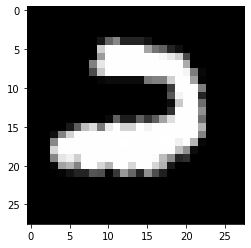

In [5]:
# Now let's see the training MNIST data as Tensors.
mnist_example = tfe.Iterator(mnist_problem.dataset(Modes.TRAIN, data_dir)).next()
image = mnist_example["inputs"]
label = mnist_example["targets"]

plt.imshow(image.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap('gray'))
print("Label: %d" % label.numpy())

In [7]:
# Fetch the problem
ende_problem = problems.problem("translate_ende_wmt32k")

# Copy the vocab file locally so we can encode inputs and decode model outputs
# All vocabs are stored on GCS
vocab_name = "vocab.translate_ende_wmt32k.32768.subwords"
vocab_file = os.path.join(gs_data_dir, vocab_name)
!gsutil cp {vocab_file} {data_dir}

# Get the encoders from the problem
encoders = ende_problem.feature_encoders(data_dir)

# Setup helper functions for encoding and decoding
def encode(input_str, output_str=None):
  """Input str to features dict, ready for inference"""
  inputs = encoders["inputs"].encode(input_str) + [1]  # add EOS id
  batch_inputs = tf.reshape(inputs, [1, -1, 1])  # Make it 3D.
  return {"inputs": batch_inputs}

def decode(integers):
  """List of ints to str"""
  integers = list(np.squeeze(integers))
  if 1 in integers:
    integers = integers[:integers.index(1)]
  return encoders["inputs"].decode(np.squeeze(integers))

'gsutil' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


ValueError: File C:\Users\admin/t2t/data\vocab.translate_ende_wmt32k.32768.subwords not found